In [10]:
import requests
import json
import prettytable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# code to: decode Months and Dates

In [11]:
code2month = {
    "M01" : "January",
    "M02" : "February",
    "M03" : "March",
    "M04" : "April",
    "M05" : "May",
    "M06" : "June",
    "M07" : "July",
    "M08" : "August",
    "M09" : "September",
    "M10" : "October",
    "M11" : "November",
    "M12" : "December"
}

month2number = {
    "January" : "01",
    "February" : "02",
    "March" : "03",
    "April" : "04",
    "May" : "05",
    "June" : "06",
    "July" : "07",
    "August" : "08",
    "September" : "09",
    "October" : "10",
    "November" : "11",
    "December" : "12"
}

def dateFrom(year, month):
    return "{}/{}".format(year,month2number[month])


# code to: decode the City/Town

In [12]:
code2citytown = {}
citytown2code = {}

file = open("bls-cities-and-towns.raw", "r")

count = 0
for line in file.readlines():
    count += 1
    ignore, code, citytownstate = line.rstrip().split(">", 2)[1].split(" ",2)
    citytown, state = citytownstate.split(",")
    code2citytown[code]=citytown
    citytown2code[citytown]=code
    #print("line: {} code: {} citytownstate: {}, citytown: {}, state: {}".format(count, code, citytownstate, citytown, state))

file.close()

def decodeCityTown(s):
    code = s[3:len(s)-2]
    return code2citytown[code]

import re
def searchDictionary(d, city):
    #print("searching for:", city)
    res = []
    for key in d.keys():
        if re.match(city, key):
            res.append(d[key])
    return res

def findCityTownCode(city):
    return searchDictionary(citytown2code, city)


# code to: decode the State

In [13]:
code2state = {}

file = open("bls-state-codes.raw", "r")

count = 0
for line in file.readlines():
    count += 1
    ignore, code, state = line.rstrip().split(">", 2)[1].split(" ",2)
    code2state[code]=state
    #print("line: {} code: {} state: {}".format(count, code, state))

file.close()

def decodeState(s):
    code = s[5:7]
    return code2state[code]


# code to: decode the Measure

In [31]:
code2measure = {
    "03" : "unemployment-rate",
    "04" : "unemployment",
    "05" : "employment",
    "06" : "labor-force"
}

measure2Code = {
    "unemployment-rate" : "03",
    "unemployment" : "04",
    "employment" : "05",
    "labor-force" : "06"
}

def findMeasureCode(s):
    return measure2Code[s]

def decodeMeasure(s):
    code = s[len(s)-2:]
    return code2measure[code]


# input parameters for data request

In [58]:
city = "Philadelphia"
startYear = 2008
endYear = 2017

seasonalAdjustment = "no"
measure = "unemployment-rate"

# construct the BLS Series ID

In [59]:
dataSet = "LA"

if seasonalAdjustment == "yes":
    saCode = "S"
else:
    saCode = "U"

cityCode = findCityTownCode(city)

measureCode = findMeasureCode(measure)

# an array of strings which represent BLS Series IDs
# seriesID = ['LAUMT423798000000003']
# seriesID = ['LAUCT426000000000003']

seriesID = ["{}{}{}{}".format(dataSet, saCode, cityCode[0], measureCode)]

In [60]:
print(seriesID)

['LAUCT426000000000003']


# build the data request

In [61]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": seriesID,"startyear":"{}".format(startYear), "endyear":"{}".format(endYear)})

# send the request

In [62]:
# get the data using API
p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=data, headers=headers)

# extract the JSON data payload from the response

In [63]:
json_data = json.loads(p.text)

# define the resulting dataset columns

In [64]:
colNames = ["seriesid","year","month","period","date","state","city","measure","value","footnotes"]

# extract and process the JSON payload into a *PrettyTable*  and a plain Python array...

In [65]:
data = []
for series in json_data['Results']['series']:
    x=prettytable.PrettyTable(colNames)
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['period']
        month = code2month[period]
        date = dateFrom(year, month)
        state = decodeState(seriesId)
        city = decodeCityTown(seriesId)
        measure = decodeMeasure(seriesId)
        value = item['value']
        footnotes=""
        for footnote in item['footnotes']:
            if footnote:
                footnotes = footnotes + footnote['text'] + ','
        if 'M01' <= period <= 'M12':
            row = [seriesId,year,month,period,date,state,city,measure,value,footnotes[0:-1]]
            x.add_row(row)
            data.append(row)

# create a *DataFrame*

In [66]:
df = pd.DataFrame(data, columns=colNames)

In [67]:
df.head()

,seriesid,year,month,period,date,state,city,measure,value,footnotes
0,LAUCT426000000000003,2017,August,M08,2017/08,Pennsylvania,Philadelphia County/city,unemployment-rate,6.7,Preliminary.
1,LAUCT426000000000003,2017,July,M07,2017/07,Pennsylvania,Philadelphia County/city,unemployment-rate,6.9,
2,LAUCT426000000000003,2017,June,M06,2017/06,Pennsylvania,Philadelphia County/city,unemployment-rate,6.4,
3,LAUCT426000000000003,2017,May,M05,2017/05,Pennsylvania,Philadelphia County/city,unemployment-rate,6.7,
4,LAUCT426000000000003,2017,April,M04,2017/04,Pennsylvania,Philadelphia County/city,unemployment-rate,5.9,


# load the national unemployment data
file created from data presented at: http://www.ncsl.org/research/labor-and-employment/national-employment-monthly-update.aspx

In [68]:
file = open("bls-national-unemployment.raw", "r")
data = []

count = 0
for line in file.readlines():
    count += 1
    line2 = re.sub(' +',' ', line.rstrip())
    fields = [f.strip() for f in line2.split("\t")]
    #print(count,fields)
    data.append(fields)
    
file.close()

In [69]:
data2 = []
for i in range(1, len(data)):
    #print(i, data[i])
    row = data[i]
    year = row[0]
    for j in range(1,len(row)):
        month = "{0:02}".format(j)
        #print(i,j,year,month,row[j])
        row2 = ["national-unemployment","{}/{}".format(year,month),row[j]]
        data2.append(row2)

In [70]:
df2 = pd.DataFrame(data2, columns=["measure","date","value"])
df2 = df2.sort_values('date')

In [71]:
df2.head()

,measure,date,value
105,national-unemployment,2008/01,4.9
106,national-unemployment,2008/02,4.8
107,national-unemployment,2008/03,5.1
108,national-unemployment,2008/04,5.0
109,national-unemployment,2008/05,5.5


# plot the city data
(this is based on the Matplotlib example here: https://matplotlib.org/examples/api/date_demo.html )

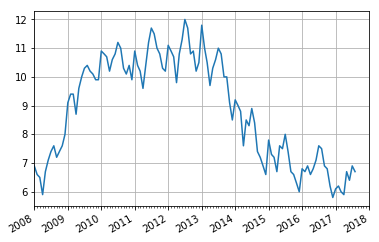

In [72]:
"""
================
Date tick labels
================

Show how to make date plots in matplotlib using date tick locators and
formatters.  See major_minor_demo1.py for more information on
controlling major and minor ticks

All matplotlib date plotting is done by converting date instances into
days since the 0001-01-01 UTC.  The conversion, tick locating and
formatting is done behind the scenes so this is most transparent to
you.  The dates module provides several converter functions date2num
and num2date

"""
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df.date.values])
y = list(df.value.values)

fig, ax = plt.subplots()
ax.plot(x, y)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

# plot the national data

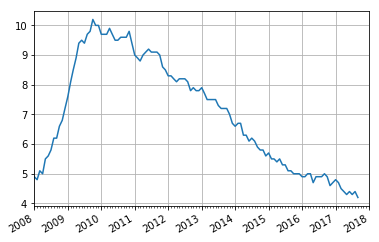

In [53]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
y = list(df2.value.values)

fig, ax = plt.subplots()
ax.plot(x, y)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

# plot both national and city data

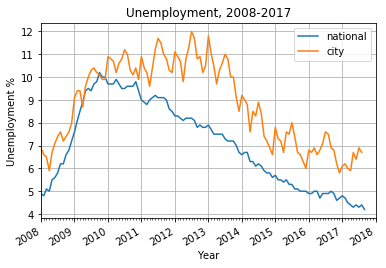

In [86]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

x1 = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
y1 = list(df2.value.values)

x2 = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df.date.values])
y2 = list(df.value.values)

fig, ax = plt.subplots()
ax.plot(x1, y1, x2, y2)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("Unemployment, 2008-2017")
plt.xlabel("Year")
plt.ylabel("Unemployment %")
plt.legend(['national','city'])
plt.show()